<a href="https://colab.research.google.com/github/kento-koyama/bayesian_predictive_micro_ICPMF12/blob/main/Workshop_(growth).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fitting of Bayesian model
##Installation and Loading libraries.  
>**pystan**: Bayesian MCMC  
>**nest_asyncio**: Library for stan in notebook.  
>**pandas**: Data manipulation  
> **numpy**: Data calculation  
>**seaborn**: Visualization  
>**matplotlib.pyplot**: Visualization  
>**arviz**: Visualization of pystan  
   
- The softwares will be installed in the temporary cloud computer.  
- **Nothing will be installed in your own PC**. 
- It must be installed at the very beginning of every calculation.   
- The installation could take a little time.

In [ ]:
# Installation
!pip install pystan
!pip install nest_asyncio
# Importing
import nest_asyncio
nest_asyncio.apply()
import stan 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import math
import arviz as az
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 KB 3.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Data reading and preperation

The data imported from reported article through github: [Hiura, S., Abe, H., Koyama, K. & Koseki, S. Bayesian generalized linear model for simulating bacterial inactivation/growth considering variability and uncertainty. Front. Microbiol. 12, 674364 (2021)](https://doi.org/10.3389/fmicb.2021.674364).

In [ ]:
#import data 
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/growth/data/bayesian_fitting.csv"
data = pd.read_csv(url, encoding='utf-8')
TIME = data['TIME']
N = data['Nt']
N_new = N *(10 ** data['Dilution'])
data['N_new'] = N_new
N_new = data['N_new']
N0_objective = data['N0_objective']
Initial = data['Initial']

In [ ]:
data

,TIME,Nt,Dilution,N0_objective,Initial,N_new
0,0,65,2,10000,1,6500
1,0,56,2,10000,2,5600
2,0,64,2,10000,3,6400
3,2,79,2,10000,0,7900
4,2,61,2,10000,0,6100
5,2,76,2,10000,0,7600
6,4,222,2,10000,0,22200
7,4,235,2,10000,0,23500
8,4,218,2,10000,0,21800
9,6,84,3,10000,0,84000


##Model construction
- The `stan_code` include a the *script* for stan (C language).  
- The stan script is constructed by several sections.

###Data section
Definition of the input data shape  

    data {
      int K;
      real TIME[K];
      int N_new[K];
      real N0_objective[K];
      int Initial[K]; 
    }

###Transformed data section
Changing the expression of the data  
日浦のところから持ってくる

    transformed data{
  	int N0[K];
	  for (k in 1:K) {
		N0[k] = poisson_rng(N0_objective[k]); 	
	  }
    }

###Parameters section
Setting of the parameters  

    parameters {
      real mu;
      real lag;
      real n0;
    }
###Transformed parameters section
Changing expression and define the prediction   
Equation from the lag-linear model:


\begin{cases}
  log_{10}N_{(t)pred} = log_{10}N_{0} & (t < lag) \\\
  log_{10}N_{(t)pred} = log_{10}N_{0}\times exp(\mu \times (t-\lambda))& (t \ge lag)
\end{cases}
  
  The negative binomial distribution $Negbin(N_{0},p)$, describing the growth amount (CFU), needs the probability as for the stochastic calculation.

\begin{equation} 
  p= \frac{N_{0}}{N_{(t)pred}} \space\space\space\space (t \ge lag)
\end{equation}
    
    transformed parameters {
      real p[K];
      for (k in 1:K) {
          p[k] = exp((-mu) * (TIME[k]-lag));
		  if (TIME[k] <= lag) {
			  p[k] = 0;
		  }
		  else {
			  p[k] = exp((-mu) * (TIME[k]-lag));
		  }
	  }
    }
###Model section
Definition of prior distributions  

    model {
	  for (k in 1:K) {
		if (Initial[k] != 0) {
		  N_new[Initial[k]] ~ poisson(n0);
		}
		if (Initial[k] == 0 ) {
          if ( N_new[k] >= N0[k] ) {
            (N_new[k]-N0[k]) ~ neg_binomial(n0, p[k]) ; 
          }
          else {
            N_new[k] ~ poisson(n0);
          }	
        }
      }
    }

In [ ]:
#parameter estimation
#compile

stan_code = """
  data {
    int K;
    real TIME[K];
    int N_new[K];
    real N0_objective[K];
    int Initial[K]; 
  }

  transformed data{
  	int N0[K];
	  for (k in 1:K) {
		  N0[k] = poisson_rng(N0_objective[k]); 	
	  }
  }

  parameters {
    real mu;
    real lag;
    real n0;
  }

  transformed parameters {
      real p[K];
      for (k in 1:K) {
          p[k] = exp((-mu) * (TIME[k]-lag));
		  if (TIME[k] <= lag) {
			  p[k] = 0;
		  }
		  else {
			  F[k] = exp((-mu) * (TIME[k]-lag));
		  }
	  }
  }

  model {
	  for (k in 1:K) {
		  if (Initial[k] != 0) {
			  N_new[Initial[k]] ~ poisson(n0);
		  }
		  if (Initial[k] == 0 ) {
			  if ( N_new[k] >= N0[k] ) {
				  (N_new[k]-N0[k]) ~ neg_binomial(n0, p[k]) ; 
			  }
			  else {
				  N_new[k] ~ poisson(n0);
			  }	
		  }
	  }
  }
"""



In [ ]:
stan_data = data.to_dict('list')
stan_data.update({'K':len(data)})

In [ ]:
posterior = stan.build(stan_code, data=stan_data)

Building...



Building: 50.9s, done.Messages from stanc:
Warning in '/tmp/httpstan_5bsd45hr/model_axk2i3qm.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_5bsd45hr/model_axk2i3qm.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_5bsd45hr/model_axk2i3qm.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to


In [ ]:
#MCMC sampling
fit_nuts = posterior.sample(num_samples=2500, num_chains=4, num_warmup = 5000)

Sampling:   0%
Sampling:   3% (800/30000)
Sampling:   5% (1400/30000)
Sampling:  10% (2900/30000)
Sampling:  13% (4000/30000)
Sampling:  18% (5400/30000)
Sampling:  23% (6800/30000)
Sampling:  26% (7800/30000)
Sampling:  29% (8600/30000)
Sampling:  36% (10900/30000)
Sampling:  37% (11200/30000)
Sampling:  47% (14000/30000)
Sampling:  59% (17600/30000)
Sampling:  60% (18000/30000)
Sampling:  61% (18400/30000)
Sampling:  62% (18600/30000)
Sampling:  63% (18800/30000)
Sampling:  64% (19300/30000)
Sampling:  65% (19600/30000)
Sampling:  67% (20100/30000)
Sampling:  68% (20400/30000)
Sampling:  70% (20900/30000)
Sampling:  71% (21400/30000)
Sampling:  82% (24500/30000)
Sampling: 100% (30000/30000)
Sampling: 100% (30000/30000), done.
Messages received during sampling:
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is a

/usr/local/lib/python3.9/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'lag'}>, <Axes: title={'center': 'lag'}>],
       [<Axes: title={'center': 'n0'}>, <Axes: title={'center': 'n0'}>],
       [<Axes: title={'center': 'F'}>, <Axes: title={'center': 'F'}>]],
      dtype=object)

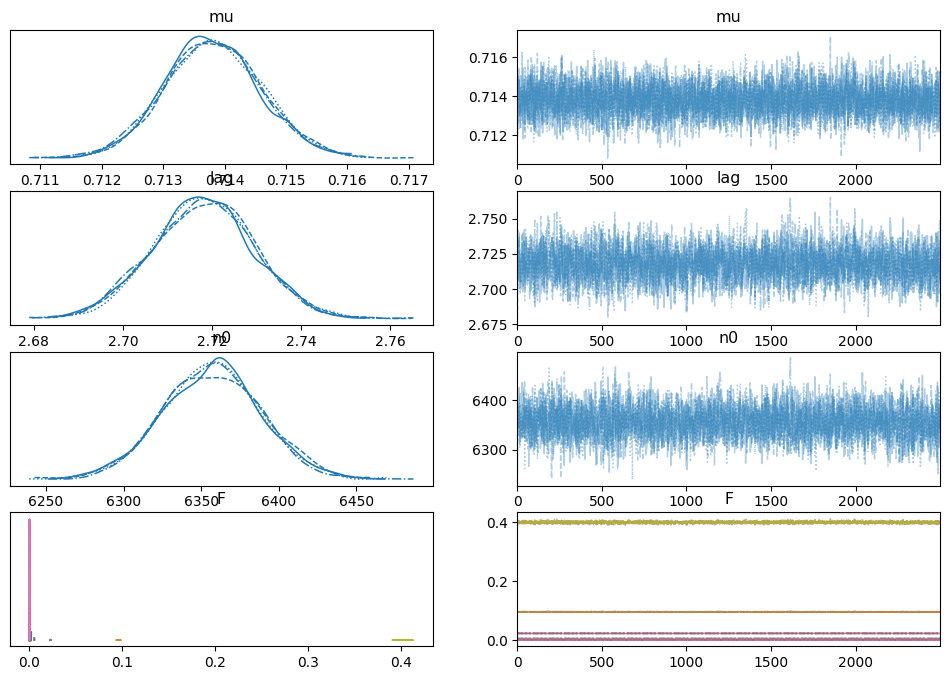

In [ ]:
az.plot_trace(fit_nuts)

In [ ]:
mu = fit_nuts['mu'][0,:].T #scale parameter(δ)
lag = fit_nuts['lag'][0,:].T #shape parameter(p)

In [ ]:
#correlation
def corrfunc(x, y, **kws):
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.axis('on')
    txtcolor = 'black' if math.fabs(r) < 0.5 else 'white'
    ax.text(.5, .5, 'Corr:\n{:.2f}'.format(r),color=txtcolor, fontsize=28, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:181: UserWarning: The label '_nolegend_' of <matplotlib.patches.Patch object at 0x7f0aefe86130> starts with '_'. It is thus excluded from the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


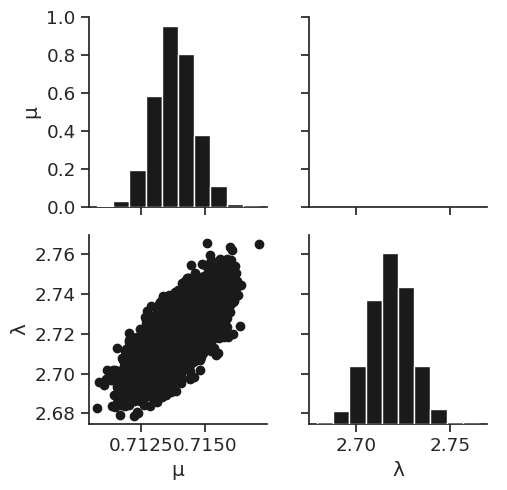

In [ ]:
#pairplot
sns.set(style='ticks', font_scale=1.2)
d = pd.DataFrame({'µ':mu, 'λ':lag},columns=['µ', 'λ'])
g = sns.PairGrid(d)
g = g.map_diag(plt.hist,color='k')
g = g.map_lower(plt.scatter,color='k')
g = g.map_upper(corrfunc)
g = g.add_legend()

In [ ]:
#data load (frequentism)
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/growth/data/frequentism_fitting.csv"
data = pd.read_csv(url, encoding='utf-8')

t = data['TIME']
N = data['Nt']
N0 = N[0]

#fitting (frequentism)
parameter_initial = np.array([0.8,1.2])
def func(t,mu, lag):
    N = N0 + (0*(t<=lag) + np.log10(np.exp(mu*(t-lag)))*(t>lag))
    return N
parameter_optimal, covariance= scipy.optimize.curve_fit(func, t, N, p0=parameter_initial)
print("mu =", format(parameter_optimal[0]))
print("lag =", format(parameter_optimal[1]))

#prediction of fitting (frequentism)
T = np.arange(0,18.05,0.05)
Y = func(T,parameter_optimal[0],parameter_optimal[1])

#calculate RMSE
T1 = np.arange(0,18,2)
Y1 = []
for j in range(len(T1)):
    y1 = Y[T1[j]*20]
    Y1.append(y1)
RMSE = np.sqrt(mean_squared_error(Y1,N))
print("RMSE= ", format(RMSE))

mu = 0.6793805117000169
lag = 2.17500556734342
RMSE=  0.04581597288412527


In [ ]:
#fitting by bayesian 
mu = fit_nuts['mu'][0,:].T #scale parameter(δ)
lag = fit_nuts['lag'][0,:].T #shape parameter(p)
N0_mean = 6167

#time
T2 = []
for i in range(180):
    t = i * 0.1
    T2.append(t)
#confidence interval
y_conf_int = np.zeros((len(mu),len(T2)))
for i in range(len(mu)):
    N0 = N0_mean
    for j in range(len(T2)):
        if N0 == 0:
            y_conf_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T2[j]-lag[i]))) <= 1:
            y_conf_int[i,j] = N0*(math.exp(mu[i]*(T2[j]-lag[i])))
        else:
            y_conf_int[i,j] = N0

y_conf_upper0 = y_conf_int[y_conf_int[:,0] != 0]
y_conf_upper0_975 = np.percentile(y_conf_upper0, 2.5, axis=0)
y_conf_upper0_025 = np.percentile(y_conf_upper0, 97.5, axis=0)
y_conf_upper0_500 = np.percentile(y_conf_upper0, 50.0, axis=0)
y_conf = np.log10(y_conf_upper0)
y_conf_975 = np.percentile(y_conf, 2.5, axis=0)
y_conf_025 = np.percentile(y_conf, 97.5, axis=0)
y_conf_500 = np.percentile(y_conf, 50.0, axis=0)

#predicted interval
y_pred_int = np.zeros((len(mu),len(T2)))
for i in range(len(mu)):
    N0 = np.random.poisson(N0_mean)
    for j in range(len(T2)):
        if N0 == 0:
            y_pred_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T2[j]-lag[i]))) <= 1:
            y_pred_int[i,j] = N0 + np.random.negative_binomial(N0, N0/(N0*math.exp(mu[i]*(T2[j]-lag[i]))), size=1)
        else:
            y_pred_int[i,j] = N0

y_pred_upper0 = y_pred_int[y_pred_int[:,0] != 0]
y_pred_upper0_975 = np.percentile(y_pred_upper0, 2.5, axis=0)
y_pred_upper0_025 = np.percentile(y_pred_upper0, 97.5, axis=0)
y_pred_upper0_500 = np.percentile(y_pred_upper0, 50.0, axis=0)
y_pred = np.log10(y_pred_upper0)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)


<Figure size 640x480 with 0 Axes>

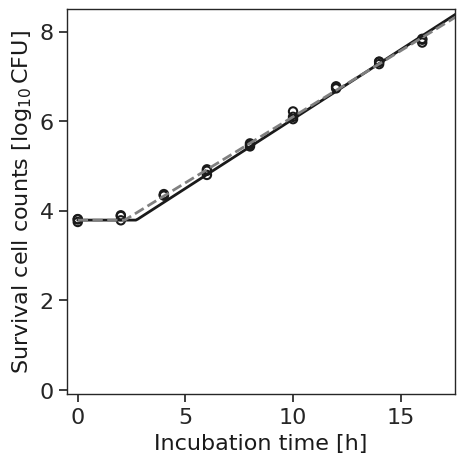

In [ ]:
#graph
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/growth/data/bayesian_fitting.csv"
data2 = pd.read_csv(url, encoding='utf-8')
TIME = data2['TIME']
N1 = data2['Nt']
N_new = N1 *(10 ** data2['Dilution'])
data2['N_new'] = N_new
fig = plt.figure()
plt.style.use('ggplot')
sns.set_style(style='ticks')
plt.figure(figsize=(5,5))
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.xlabel('Incubation time [h]', fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')
plt.xlim(-0.5,17.5)
plt.ylim(-0.1,8.5)
plt.xticks([0,5,10,15])
plt.scatter(TIME, np.log10(N_new), edgecolors ='k', facecolors='none', linewidths=1.5)
plt.plot(T2,y_conf_500, linestyle = 'solid', zorder=1, color='k', lw=2.0) #bayesian
plt.plot(T,Y,color='gray',linestyle='dashed',lw=2,zorder=2) #frequentism

In [ ]:
# data import
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/growth/data/2cell.csv"
data = pd.read_csv(url, encoding='utf-8')
time = data['TIME']
N = data['Nt']
N_new = N *(10 ** data['Dilution'])
data['N_new'] = N_new

In [ ]:
#time for prediction
T = []
for i in range(211):
    t = i * 0.05
    T.append(t)

In [ ]:
N0_mean = 2 #initial cell number(average)

#prediction interval
y_pred_int = np.zeros((len(mu),len(T)))
for i in range(len(mu)):
    N0 = np.random.poisson(N0_mean)
    for j in range(len(T)):
        if N0 == 0:
            y_pred_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))) <= 1:
            y_pred_int[i,j] = N0 + np.random.negative_binomial(N0, N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))), size=1)
        else:
            y_pred_int[i,j] = N0

y_pred_upper0 = y_pred_int[y_pred_int[:,0] != 0]
y_pred_upper0_975 = np.percentile(y_pred_upper0, 2.5, axis=0)
y_pred_upper0_025 = np.percentile(y_pred_upper0, 97.5, axis=0)
y_pred_upper0_500 = np.percentile(y_pred_upper0, 50.0, axis=0)
y_pred = np.log10(y_pred_upper0)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)

In [ ]:
#confidence interval
y_conf_int = np.zeros((len(mu),len(T)))
for i in range(len(mu)):
    N0 = N0_mean
    for j in range(len(T)):
        if N0 == 0:
            y_conf_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))) <= 1:
            y_conf_int[i,j] = N0*(math.exp(mu[i]*(T[j]-lag[i])))
        else:
            y_conf_int[i,j] = N0

y_conf_upper0 = y_conf_int[y_conf_int[:,0] != 0]
y_conf_upper0_975 = np.percentile(y_conf_upper0, 2.5, axis=0)
y_conf_upper0_025 = np.percentile(y_conf_upper0, 97.5, axis=0)
y_conf_upper0_500 = np.percentile(y_conf_upper0, 50.0, axis=0)
y_conf = np.log10(y_conf_upper0)
y_conf_975 = np.percentile(y_conf, 2.5, axis=0)
y_conf_025 = np.percentile(y_conf, 97.5, axis=0)
y_conf_500 = np.percentile(y_conf, 50.0, axis=0)

In [ ]:
#accuracy
Time = [0,2,4,6,8,10]
i = [0,1,2,3,4,5]
num = [50,50,50,50,50,49] #number of data
evaluation =[]
ZERO = []
for t,i in zip(Time,i):
    T1 = int(t/0.05)
    y_pred_min = y_pred_upper0_975[T1]
    y_pred_max = y_pred_upper0_025[T1]
    hani =[]
    repetition = num[i]
    for j in range(repetition):
        number = sum(num[0:i])+j
        N = N_new[number]
        if N == 0:
            ans = 2
        elif y_pred_min <= N <= y_pred_max :    
            ans= 1
        else:
            ans=0
        hani.append(ans)
    correct =hani.count(1)
    zero = hani.count(2)
    ZERO.append(zero)
    evaluation.append(correct)
accuracy = (sum(evaluation)/((sum(num)-sum(ZERO))))*100

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

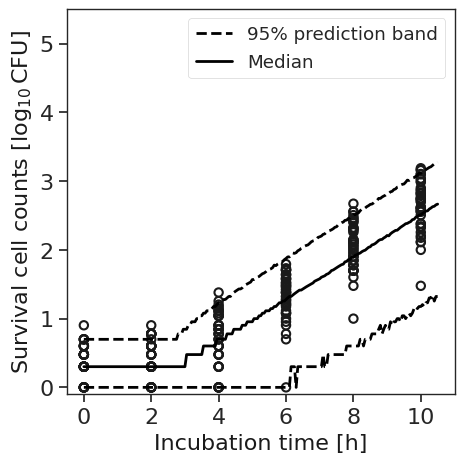

In [ ]:
#graph
fig = plt.figure()
plt.style.use('ggplot')
sns.set_style(style='ticks')
plt.figure(figsize=(5,5))
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.xlabel('Incubation time [h]', fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')
plt.xlim(-0.5,11)
plt.ylim(-0.1,5.5)
plt.xticks([0,2,4,6,8,10])
plt.scatter(time, np.log10(N_new), zorder=2, facecolors ='none',edgecolors='k',linewidth=1.5)

#prediction interval
plt.plot(T,y_pred_025, linestyle = 'dashed', zorder=2, color='black', lw=2.0)
plt.plot(T,y_pred_975, linestyle = 'dashed', zorder=2, color='black', lw=2.0, label='95% prediction band')
plt.plot(T,y_pred_500, linestyle = 'solid', zorder=2, color='black', lw=2.0, label='Median')

plt.legend()
plt.show()